# Building powerful image classification models using very little data
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  

- training a small network from scratch (as a baseline)
- using the bottleneck features of a pre-trained network
- fine-tuning the top layers of a pre-trained network

# Prepare data

### Dogs vs. Cats 
https://www.kaggle.com/c/dogs-vs-cats

The original dataset contains 12,500 cats and 12,500 dogs in the training set. But we only use 1000 images per class as our training set to showcase how to encounter the issue of little amount of training data.  
We also use 400 additional samples from each class as validation data, to evaluate our models.  

In [6]:
import os
from shutil import copyfile
import numpy as np

In [3]:
# take a look at the data
i = 0
for f in os.listdir('train'):
    print f
    i += 1
    if i > 10:
        break

cat.3075.jpg
dog.1493.jpg
dog.1651.jpg
dog.12436.jpg
dog.9633.jpg
cat.11055.jpg
dog.2250.jpg
dog.8192.jpg
cat.4073.jpg
dog.3927.jpg
cat.8937.jpg


In [5]:
# prepare training set (1000 images per class)
os.makedirs('data/train')
os.makedirs('data/train/cats')
os.makedirs('data/train/dogs')

for i in range(1000):
    copyfile('train/cat.%d.jpg' % i, 'data/train/cats/cat.%d.jpg' % i)
    copyfile('train/dog.%d.jpg' % i, 'data/train/dogs/dog.%d.jpg' % i)

In [8]:
# prepare validation set (400 images per class by random sampling)
sample_indices = np.random.choice(range(1000, 12500), 400, replace=False)

print len(sample_indices)
print len(np.unique(sample_indices))

400
400


In [11]:
# prepare validation set (400 images per class)
os.makedirs('data/validation')
os.makedirs('data/validation/cats')
os.makedirs('data/validation/dogs')

for i in sample_indices:
    copyfile('train/cat.%d.jpg' % i, 'data/validation/cats/cat.%d.jpg' % i)
    copyfile('train/dog.%d.jpg' % i, 'data/validation/dogs/dog.%d.jpg' % i)

In [13]:
! tree -d data

data
├── train
│   ├── cats
│   └── dogs
└── validation
    ├── cats
    └── dogs

6 directories


# deep learning for small-data problems
Convolutional neural networks --a pillar algorithm of deep learning-- are by design one of the best models available for most "perceptual" problems (such as image classification), even with very little data to learn from. Training a convnet from scratch on a small image dataset will still yield reasonable results, without the need for any custom feature engineering. Convnets are just plain good. They are the right tool for the job.  

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes, as we will see in this post. Specifically in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data.

# Data pre-processing and data augmentation
In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

```python
# check default setting
datagen = ImageDataGenerator(
    featurewise_center=False, # Set input mean to 0 over the dataset, feature-wise
    samplewise_center=False, # Set each sample mean to 0
    featurewise_std_normalization=False, # Divide inputs by std of the dataset, feature-wise
    samplewise_std_normalization=False, # Divide each input by its std
    zca_whitening=False, # Apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0.0, # Degree range for random rotations.
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.0, # Range for random zoom
    channel_shift_range=0.0, # Range for random channel shifts
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    # rescaling factor. we multiply the data by the value provided 
    # (before applying any other transformation)
    preprocessing_function=None, 
    # function that will be implied on each input. 
    # The function will run after the image is resized and augmented. 
    # The function should take one argument: one image (Numpy tensor with rank 3), 
    # and should output a Numpy tensor with the same shape.
    data_format=None, 
    validation_split=0.0)
```

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [16]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [18]:
# try to generate 15 images
raw_img = load_img('data/train/cats/cat.78.jpg')
x = img_to_array(raw_img)
print x.shape

# convert to tensor
x = x.reshape((1, ) + x.shape)
print x.shape

(499, 499, 3)
(1, 499, 499, 3)


In [19]:
i = 0
gen_images = []
for batch in datagen.flow(x, batch_size=1):
    gen_images.append(batch)
    i += 1
    if i > 15:
        # otherwise the generator would loop indefinitely
        break

In [20]:
print len(gen_images)
print gen_images[0].shape

16
(1, 499, 499, 3)


In [24]:
# show the generate images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

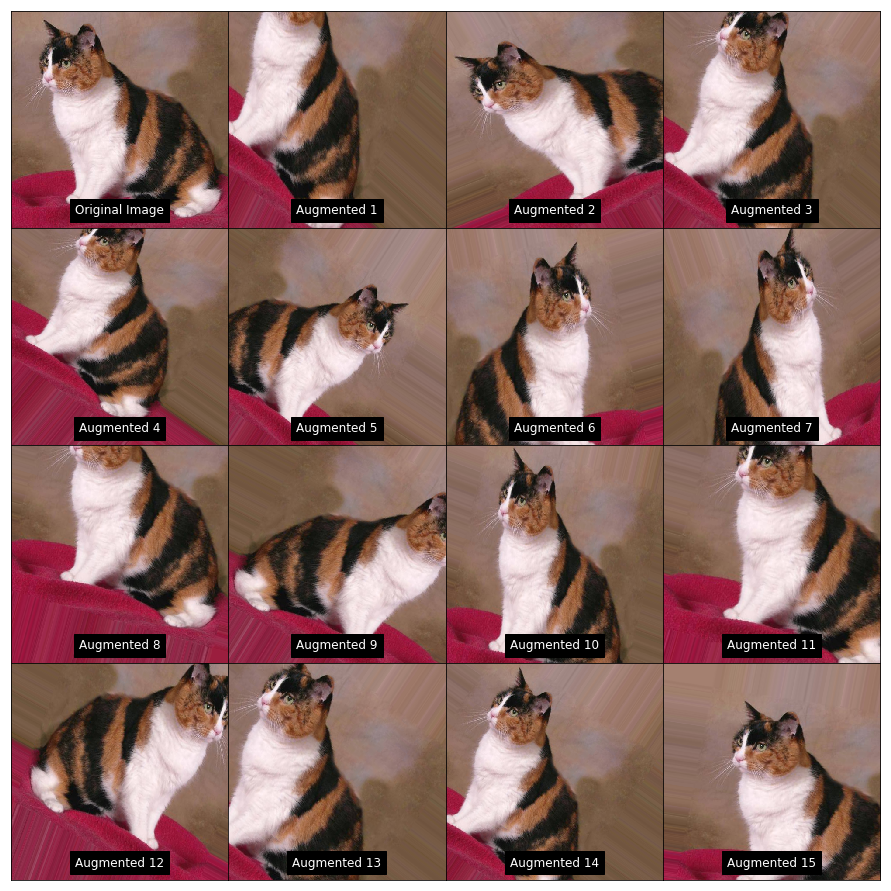

In [47]:
fig = plt.figure(1, (16, 16))
grids = ImageGrid(fig, 111, nrows_ncols = (4, 4), axes_pad=0)

grids[0].imshow(raw_img)
grids[0].text(0.5, 0.05, 'Original Image', verticalalignment='bottom', horizontalalignment='center',
              transform=grids[0].transAxes, color='white', fontsize=12, bbox={'facecolor':'black', 'pad': 5})

for i in range(1, 16):
    grids[i].imshow(array_to_img(gen_images[i-1][0]))
    grids[i].text(0.5, 0.05, 'Augmented %d' %(i), verticalalignment='bottom', horizontalalignment='center',
                  transform=grids[i].transAxes, color='white', fontsize=12, bbox={'facecolor':'black', 'pad': 5})
    grids[i].set_xticks([])
    grids[i].set_yticks([])
    
plt.show()

# Training a small convnet from scratch: 80% accuracy in 40 lines of code
Since we only have few examples, our number one concern should be overfitting.   
**Overfitting** happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.    
For instance, if you, as a human, only see three images of people who are lumberjacks, and three, images of people who are sailors, and among them only one lumberjack wears a cap, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.  

**Data augmentation** is one way to fight overfitting, but it isn't enough since our augmented samples are still highly correlated. Your main focus for fighting overfitting should be the entropic capacity of your model --how much information your model is allowed to store.   
A model that can store a lot of information has the potential to be more accurate by leveraging more features, but it is also more at risk to start storing irrelevant features.     
Meanwhile, a model that can only store a few features will have to focus on the most significant features found in the data, and these are more likely to be truly relevant and to generalize better.  

There are different ways to modulate entropic capacity. The main one is the choice of the number of parameters in your model, i.e. the number of layers and the size of each layer. Another way is the use of **weight regularization**, such as L1 or L2 regularization, which consists in forcing model weights to taker smaller values.  

In our case we will use a very small convnet with few layers and few filters per layer, alongside data augmentation and **dropout**. Dropout also helps reduce overfitting, by preventing a layer from seeing twice the exact same pattern, thus acting in a way analoguous to data augmentation (you could say that both dropout and data augmentation tend to disrupt random correlations occuring in your data).  

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

In [52]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [53]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [57]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# It should contain one subdirectory per class. 
# Any PNG, JPG, BMP, PPM or TIF images inside each of the 
# subdirectories directory tree will be included in the generator.
train_generator = train_datagen.flow_from_directory('data/train', 
                                                    target_size=(150, 150), 
                                                    batch_size=batch_size, 
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory('data/validation', 
                                                              target_size=(150, 150), 
                                                              batch_size=batch_size, 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [59]:
model.fit_generator(train_generator, 
                    steps_per_epoch=2000 // batch_size, 
                    epochs=50, 
                    validation_data=validation_generator, 
                    validation_steps=800 // batch_size)
model.save_weights('baseline.h5')

Epoch 1/50
62/62 [==============================] - 16s 264ms/step - loss: 0.3479 - acc: 0.8513 - val_loss: 0.4993 - val_acc: 0.7975
Epoch 2/50
62/62 [==============================] - 16s 261ms/step - loss: 0.3397 - acc: 0.8609 - val_loss: 0.4928 - val_acc: 0.7688
Epoch 3/50
62/62 [==============================] - 16s 258ms/step - loss: 0.3452 - acc: 0.8498 - val_loss: 0.4440 - val_acc: 0.8050
Epoch 4/50
62/62 [==============================] - 16s 253ms/step - loss: 0.3616 - acc: 0.8538 - val_loss: 0.5629 - val_acc: 0.8037
Epoch 5/50
62/62 [==============================] - 15s 246ms/step - loss: 0.3414 - acc: 0.8523 - val_loss: 0.5413 - val_acc: 0.8100
Epoch 6/50
62/62 [==============================] - 15s 245ms/step - loss: 0.3094 - acc: 0.8745 - val_loss: 0.5304 - val_acc: 0.8050
Epoch 7/50
62/62 [==============================] - 15s 241ms/step - loss: 0.3479 - acc: 0.8589 - val_loss: 0.5093 - val_acc: 0.8163
Epoch 8/50
62/62 [==============================] - 15s 239ms/step - 

# Using the bottleneck features of a pre-trained network: 90% accuracy in a minute
A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.  

<img src='images/vgg16_original.png' style="height: 600px">

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.  

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.  

In [60]:
from keras import applications

In [70]:
# save_bottlebeck_features
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')

batch_size=32
train_generator = datagen.flow_from_directory('data/train', target_size=(150, 150), 
                                              batch_size=batch_size, class_mode=None, shuffle=False)
# this means our generator will only yield batches of data, no labels
# our data will be in order, so all first 1000 images will be cats, then 1000 dogs

bottleneck_features_train = model.predict_generator(train_generator, int(np.ceil(2000. / batch_size)))
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

validation_generator = datagen.flow_from_directory('data/validation', target_size=(150, 150),
                                                   batch_size=batch_size, class_mode=None, shuffle=False)
bottleneck_features_validation = model.predict_generator(validation_generator, int(np.ceil(800. / batch_size)))
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [71]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 400 + [1] * 400)

In [72]:
train_data.shape

(2000, 4, 4, 512)

In [73]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels, epochs=50, batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 0s 245us/step - loss: 0.9267 - acc: 0.7290 - val_loss: 0.3373 - val_acc: 0.8638
Epoch 2/50
2000/2000 [==============================] - 0s 195us/step - loss: 0.3569 - acc: 0.8440 - val_loss: 0.3987 - val_acc: 0.8363
Epoch 3/50
2000/2000 [==============================] - 0s 197us/step - loss: 0.3053 - acc: 0.8710 - val_loss: 0.2826 - val_acc: 0.8912
Epoch 4/50
2000/2000 [==============================] - 0s 173us/step - loss: 0.2882 - acc: 0.8895 - val_loss: 0.2591 - val_acc: 0.8925
Epoch 5/50
2000/2000 [==============================] - 0s 181us/step - loss: 0.2228 - acc: 0.9105 - val_loss: 0.3311 - val_acc: 0.8688
Epoch 6/50
2000/2000 [==============================] - 0s 197us/step - loss: 0.1974 - acc: 0.9235 - val_loss: 0.2696 - val_acc: 0.8912
Epoch 7/50
2000/2000 [==============================] - 0s 195us/step - loss: 0.1904 - acc: 0.9300 - val_loss: 0.3745 - val_acc: 0.8738
E

# Fine-tuning the top layers of a a pre-trained network
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier.   
Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:  

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block

<img src='images/vgg16_modified.png' style='height: 600px'>

- in order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
- we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
- fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [99]:
# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 32

In [86]:
# build the VGG16 network
vgg_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
print('Model loaded.')

Model loaded.


In [87]:
vgg_model.output_shape

(None, 4, 4, 512)

In [88]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [90]:
from keras.models import Model
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs= vgg_model.input, outputs= top_model(vgg_model.output))

In [91]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [97]:
from keras import optimizers

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [100]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/home/saucecat/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/saucecat/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=62, epochs=50, validation_steps=800)`


Epoch 1/50
62/62 [==============================] - 85s 1s/step - loss: 0.6165 - acc: 0.8654 - val_loss: 0.3673 - val_acc: 0.8988
Epoch 2/50
62/62 [==============================] - 85s 1s/step - loss: 0.2079 - acc: 0.9224 - val_loss: 0.3212 - val_acc: 0.9038
Epoch 3/50
62/62 [==============================] - 84s 1s/step - loss: 0.1573 - acc: 0.9481 - val_loss: 0.3199 - val_acc: 0.9137
Epoch 4/50
62/62 [==============================] - 84s 1s/step - loss: 0.1397 - acc: 0.9451 - val_loss: 0.3770 - val_acc: 0.9100
Epoch 5/50
62/62 [==============================] - 84s 1s/step - loss: 0.1125 - acc: 0.9592 - val_loss: 0.3541 - val_acc: 0.9137
Epoch 6/50
62/62 [==============================] - 83s 1s/step - loss: 0.1009 - acc: 0.9723 - val_loss: 0.3230 - val_acc: 0.9175
Epoch 7/50
62/62 [==============================] - 83s 1s/step - loss: 0.0914 - acc: 0.9672 - val_loss: 0.3304 - val_acc: 0.9237
Epoch 8/50
62/62 [==============================] - 83s 1s/step - loss: 0.0645 - acc: 0.97